# Synthetic Datasets

This notebook consists in building synthetic univariate datasets for time series forecasting. In particular, they are designed for experiments of frequency selection, noise sensitivity and multi-scale strategies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal import spectrogram

## Tools

In [11]:
def plot_series(series, start_index=100, num_samples=700, dataset='traffic', channel='5'):

    end_index = start_index + num_samples
    plt.figure(figsize=(10, 6))
    plt.plot(series[start_index:end_index])
    plt.title(f"Time Series ({num_samples} samples from time step {start_index}) (datastet: {dataset}, channel: {channel})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

def plot_series_without_noise(series, start_index=100, num_samples=200):
    end_index = start_index + num_samples
    plt.figure(figsize=(10, 6))
    plt.plot(series[start_index:end_index])
    plt.title(f"Generated time series without noise ({num_samples} samples from time step {start_index})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

def plot_series_with_noise(series, snr, start_index=100, num_samples=200):
    end_index = start_index + num_samples
    snr = round(snr, 1)
    plt.figure(figsize=(10, 6))
    plt.plot(series[start_index:end_index])
    plt.title(f"Generated time series with signal-to-noise ratio {snr} ({num_samples} samples from time step {start_index})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

def plot_spectrogram(series, N_w, N_o, sampling_rate=1):
    f, t, Sxx = spectrogram(series, fs=sampling_rate, window='hann', nperseg=N_w, noverlap=N_o, detrend=False, scaling='density', mode='psd')
    
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Intensity [dB]')
    plt.title(f'Spectrogram of the signal')
    plt.ylabel('Frequency (x3600) [Hz]')
    plt.xlabel('Time [hour]')
    plt.show()

def plot_normalized_absolute_Fourier_coefs(series, sampling_rate=1, start_index=100, num_samples=2000):

    series = series[start_index:start_index+num_samples]
    N = len(series)
    yf = rfft(series)
    xf = rfftfreq(N, 1 / sampling_rate)[:N//2]
    absolute_coefs = (2.0/N) * np.abs(yf[:N//2])
    normalized_absolute_coefs = absolute_coefs / np.sum(absolute_coefs)
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, normalized_absolute_coefs)
    plt.title(f"Normalized absolute Fourier coefficients of the generated signal ({num_samples} samples from time step {start_index})")
    plt.xlabel("Frequency (Hz) (x3600)")
    plt.ylabel("Relative amplitude")
    plt.grid()
    plt.show()

def plot_normalized_PSD(series, sampling_rate=1, start_index=100, num_samples=2000):

    series = series[start_index:start_index+num_samples]
    N = len(series)
    yf = rfft(series)
    xf = rfftfreq(N, 1 / sampling_rate)[:N//2]
    power_spectrum = (2.0/N) * np.abs(yf[:N//2])**2
    power_spectrum_norm = power_spectrum / np.sum(power_spectrum)
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, power_spectrum_norm)
    plt.title(f"Power Spectral Density of the generated signal ({num_samples} samples from time step {start_index})")
    plt.xlabel("Frequency (Hz) (x3600)")
    plt.ylabel("PSD")
    plt.grid()
    plt.show()

def plot_average_normalized_absolute_Fourier_coefs(series, sampling_rate=1, N_w=2000, N_o=1500):

    step_size = N_w - N_o
    num_segments = (len(series) - N_o) // step_size
    accumulated_coefs = None

    for i in range(num_segments):
        start_idx = i * step_size
        end_idx = start_idx + N_w
        segment = series[start_idx:end_idx]
        
        N = len(segment)
        yf = rfft(segment)
        xf = rfftfreq(N, 1 / sampling_rate)[:N//2]
        absolute_coefs = (2.0 / N) * np.abs(yf[:N//2])
        
        if accumulated_coefs is None:
            accumulated_coefs = absolute_coefs
        else:
            accumulated_coefs += absolute_coefs

    average_absolute_coefs = accumulated_coefs / num_segments
    normalized_absolute_coefs = average_absolute_coefs / np.sum(average_absolute_coefs)

    plt.figure(figsize=(10, 6))
    plt.plot(xf, normalized_absolute_coefs)
    plt.title(f"Average normalized absolute Fourier coefficients of the generated signal")
    plt.xlabel("Frequency (Hz) (x3600)")
    plt.ylabel("Relative amplitude")
    plt.grid()
    plt.show()

def plot_average_normalized_PSD(series, sampling_rate=1, N_w=2000, N_o=1500):

    step_size = N_w - N_o
    num_segments = (len(series) - N_o) // step_size
    accumulated_squared_coefs = None

    for i in range(num_segments):
        start_idx = i * step_size
        end_idx = start_idx + N_w
        segment = series[start_idx:end_idx]
        
        N = len(segment)
        yf = rfft(segment)
        xf = rfftfreq(N, 1 / sampling_rate)[:N//2]
        squared_coefs = (2.0 / N) * np.abs(yf[:N//2])**2
        
        if accumulated_squared_coefs is None:
            accumulated_squared_coefs = squared_coefs
        else:
            accumulated_squared_coefs += squared_coefs

    average_squared_coefs = accumulated_squared_coefs / num_segments
    normalized_average_squared_coefs = average_squared_coefs / np.sum(average_squared_coefs)
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, normalized_average_squared_coefs)
    plt.title(f"Average Power Spectral Density of the generated signal")
    plt.xlabel("Frequency (Hz) (x3600)")
    plt.ylabel("PSD")
    plt.grid()
    plt.show()

In [30]:
def save_to_csv(series, folder_path, file_name):
    start_date = pd.to_datetime("2016-07-01 00:00:00")
    timestamps = [start_date + pd.Timedelta(hours=i) for i in range(len(series))]
    df = pd.DataFrame({"date": timestamps, "value": series})
    df.to_csv(f"{folder_path}/{file_name}", index=False)

## Generators

In [13]:
class SNRGenerator:

    def __init__(self, length=5000, linear_trend = 0, trend_amp = [0, 8], trend_freq = [0.005, 0.026], season_amp=[4, 1, 1], season_freq = [0.06, 0.13, 0.16]):
        
        self.length = length
        self.linear_trend = linear_trend
        self.linear_component = None
        self.trend_amp = trend_amp
        self.trend_freq = trend_freq
        self.season_amp = season_amp
        self.season_freq = season_freq
        self.serie_without_noise = None

    def generate_series_without_noise(self, std_scaler = False):
        np.random.seed(2024)

        time = np.arange(0, self.length)

        self.linear_component = self.linear_trend * time

        trend = self.trend_amp[0] * np.sin(time * 2 * np.pi * self.trend_freq[0]) + self.trend_amp[1] * np.sin(time * 2 * np.pi * self.trend_freq[1]) + self.linear_component

        seasonality1 = self.season_amp[0] * np.sin(time * 2 * np.pi * self.season_freq[0])
        seasonality2 = self.season_amp[1] * np.sin(time * 2 * np.pi * self.season_freq[1])
        seasonality3 = self.season_amp[2] * np.sin(time * 2 * np.pi * self.season_freq[2])

        signal = trend + seasonality1 + seasonality2 + seasonality3
        if std_scaler:
            signal = (signal - np.mean(signal)) / np.std(signal)
        self.series_without_noise = signal
    
    def add_noise(self, snr):
        np.random.seed(2024)

        variance_series_without_noise = np.var(self.series_without_noise - self.linear_component)
        noise_scale = np.sqrt(variance_series_without_noise / (10 ** (snr / 10)))
        noised_series = self.series_without_noise + np.random.normal(loc=0, scale=noise_scale, size=self.length)
        
        return noised_series

In [16]:
class FractalGenerator:

    def __init__(self, length=5000, linear_trend = 0, amplitudes = [100, 10, 3], frequencies = [0.002, 0.02, 0.2], number_of_sinusoids = 3):
        
        self.length = length
        self.linear_trend = linear_trend
        self.linear_component = None
        self.amplitudes = amplitudes
        self.frequencies = frequencies
        self.number_of_sinusoids = number_of_sinusoids
        self.series = None

    def generate_series(self, std_scaler = False):
        np.random.seed(2024)

        time = np.arange(0, self.length)

        self.trend = self.linear_trend * time

        sinusoidal_component = 0
        for k in range(0, self.number_of_sinusoids):
            phases = np.random.uniform(0,  2* 2 * np.pi, self.number_of_sinusoids)
            sinusoidal_component += self.amplitudes[k] * np.cos(time * 2 * np.pi * self.frequencies[k] + phases[k])

        signal = self.trend + sinusoidal_component
        if std_scaler:
            signal = (signal - np.mean(signal)) / np.std(signal)

        self.series = signal

In [27]:
class MultiScaleGenerator:

    def __init__(self, length=5000, linear_trend=0.005, trend_length=200, freq_sinusoid=0.2, lambda_sigmoid=0.2, gap_length=15):
        self.length = length
        self.linear_trend = linear_trend
        self.trend_length = trend_length
        self.freq_sinusoid = freq_sinusoid
        self.lambda_sigmoid = lambda_sigmoid
        self.gap_length = gap_length
        self.series = None

    def generate_series(self, std_scaler = False):
        np.random.seed(2024)

        time = np.arange(0, self.length)

        support = np.zeros_like(time, dtype=float)
        sinusoid = np.zeros_like(time, dtype=float)

        segment_start = 0
        while segment_start < self.length:
            segment_end = min(segment_start + self.trend_length, self.length)

            linear_segment = self.linear_trend * (time[segment_start:segment_end] - time[segment_start])
            support[segment_start:segment_end] = linear_segment

            center = self.trend_length // 2
            envelope = (1 / (1 + np.exp(-self.lambda_sigmoid * (time[segment_start:segment_end] - time[segment_start] - center)))) / 2.5
            if self.linear_trend > 0:
                envelope += (self.linear_trend * center) / 40
            else:
                envelope += 1 / 40

            segment_sinusoid = np.cos(2 * np.pi * self.freq_sinusoid * time[segment_start:segment_end]) * envelope
            sinusoid[segment_start:segment_end] = segment_sinusoid

            gap_start = segment_end
            gap_end = min(segment_start + self.trend_length + self.gap_length, self.length)
            if gap_end > gap_start:
                gap_slope = np.linspace(1, 0, gap_end - gap_start)
                support[gap_start:gap_end] = gap_slope

            segment_start += self.trend_length + self.gap_length

        signal = support + sinusoid
        if std_scaler:
            signal = (signal - np.mean(signal)) / np.std(signal)

        self.series = signal

        return self.series

## Fractal Dataset

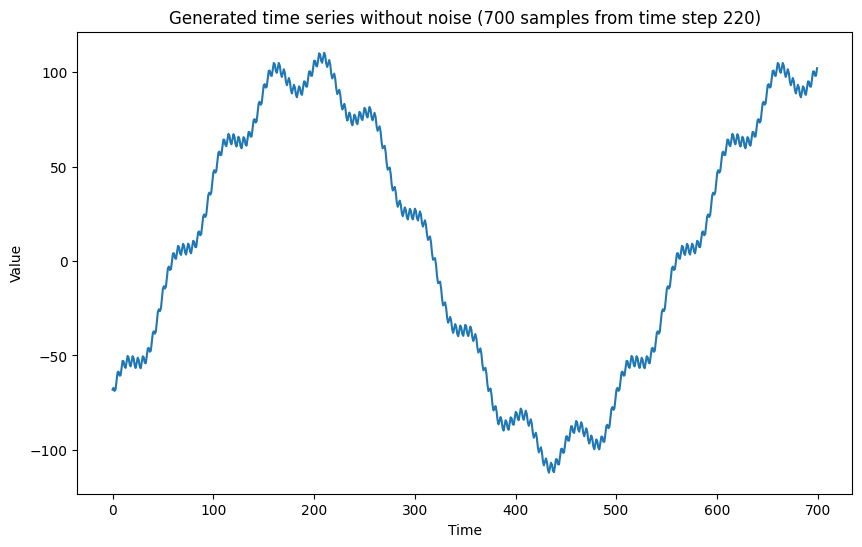

In [25]:
generator = FractalGenerator()
generator.generate_series()

series = generator.series
#save_to_csv(series, "./dataset/synthetic/", "Fractal_2.csv")

plot_series_without_noise(series, start_index=220, num_samples=700)

## Multi-Scale Dataset

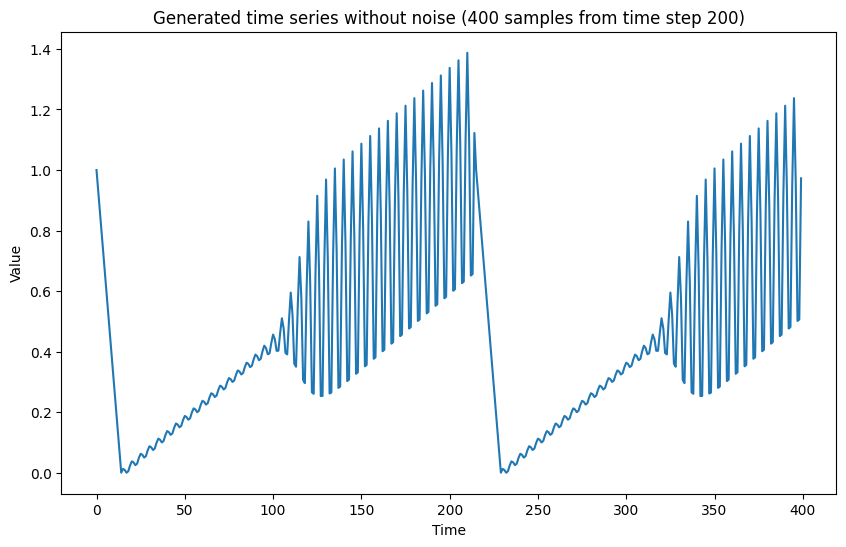

In [31]:
generator = MultiScaleGenerator()
generator.generate_series()

series = generator.series
#save_to_csv(series, "./dataset/synthetic/", "Multi_Scale.csv")

plot_series_without_noise(series, start_index=200, num_samples=400)

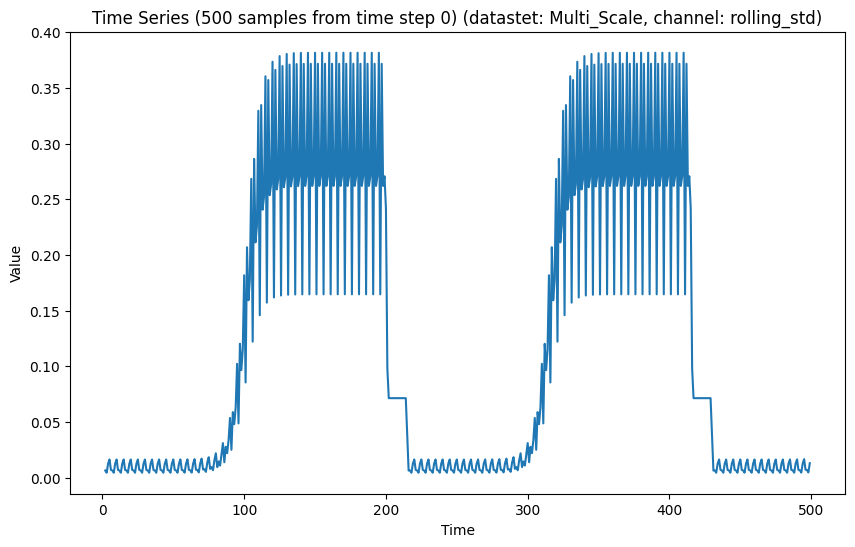

In [34]:
df = pd.read_csv("./dataset/synthetic/Multi_Scale.csv")
series = df['value']
rolling_std = series.rolling(window=3).std()
series = series.to_numpy()
plot_series(rolling_std.to_numpy(), start_index=0, num_samples=500, dataset='Multi_Scale', channel='rolling_std')

## SNR Datasets

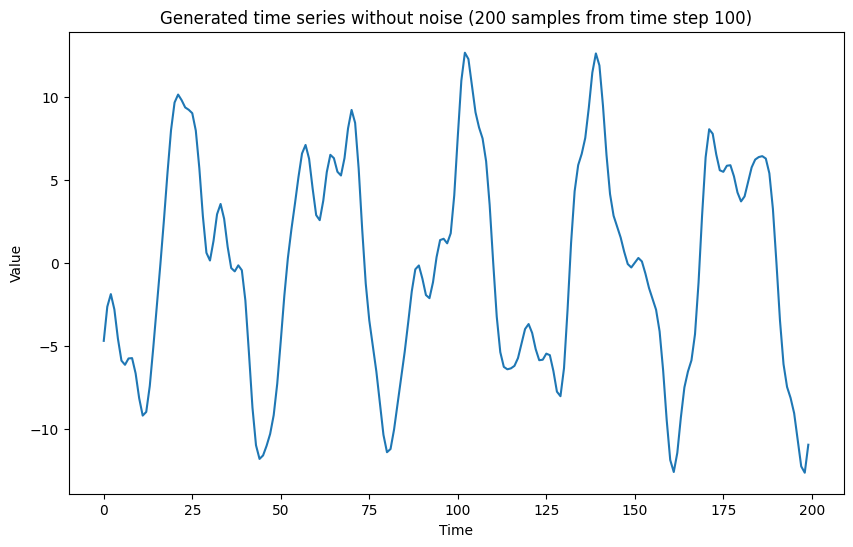

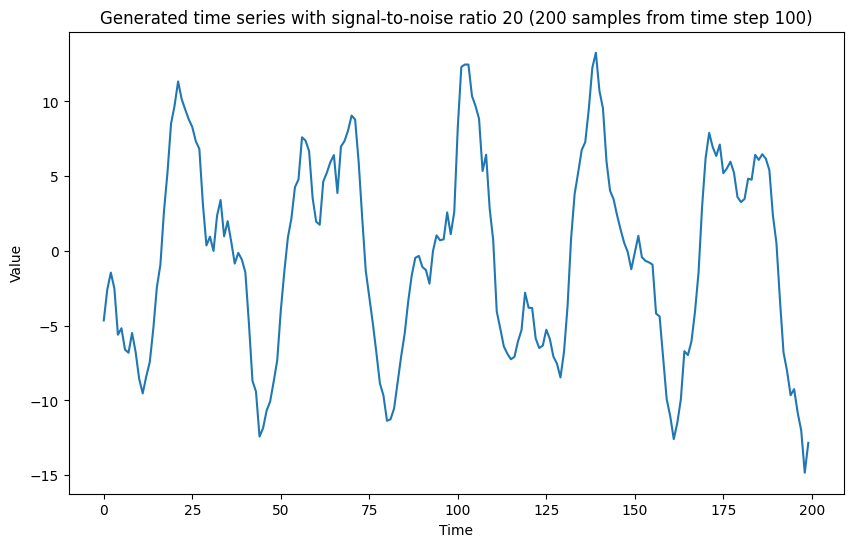

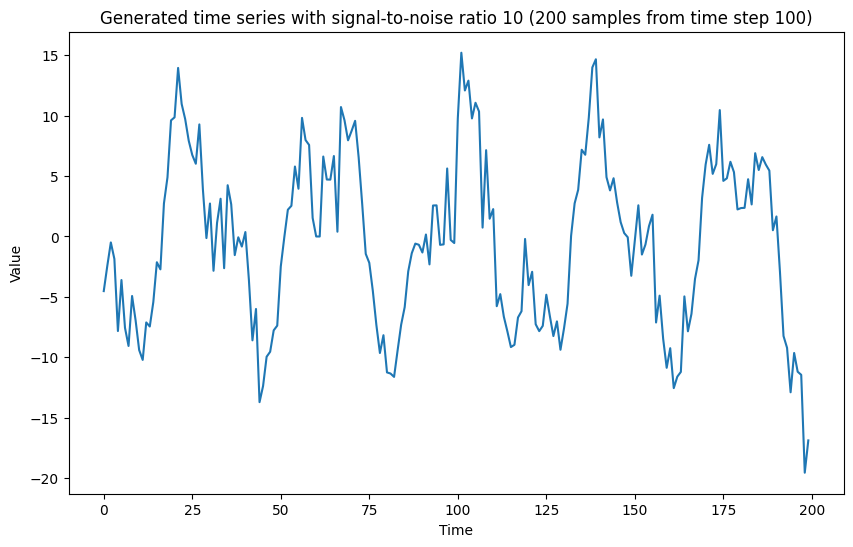

In [36]:
ts_generator = SNRGenerator()
ts_generator.generate_series_without_noise()

series_without_noise = ts_generator.series_without_noise
series_with_noise_snr_20 = ts_generator.add_noise(20)
series_with_noise_snr_10 = ts_generator.add_noise(10)

# save_to_csv(series_without_noise, "./dataset/synthetic/", "Simple_SNR_infty.csv")
# save_to_csv(series_with_noise_snr_20, "./dataset/synthetic/", "Simple_SNR_20.csv")
# save_to_csv(series_with_noise_snr_10, "./dataset/synthetic/", "Simple_SNR_10.csv")

plot_series_without_noise(series_without_noise, start_index=100, num_samples=200)
plot_series_with_noise(series_with_noise_snr_20, snr=20, start_index=100, num_samples=200)
plot_series_with_noise(series_with_noise_snr_10, snr=10, start_index=100, num_samples=200)

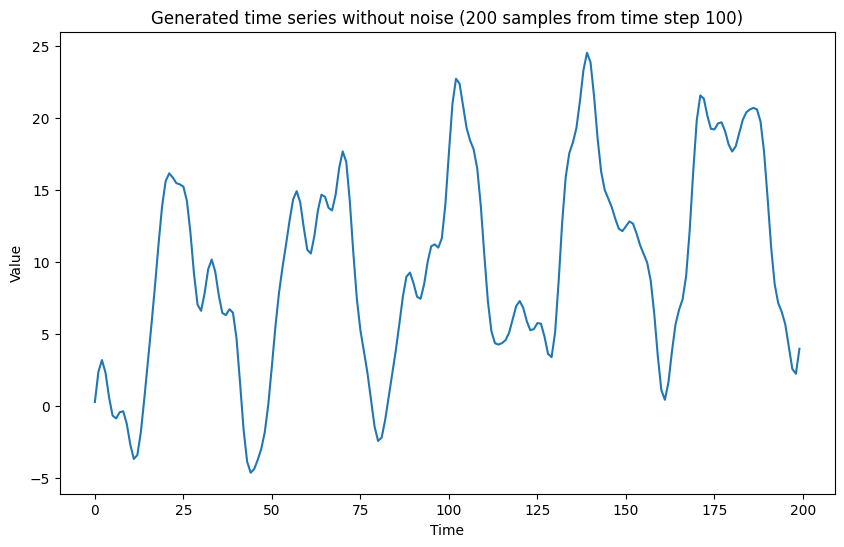

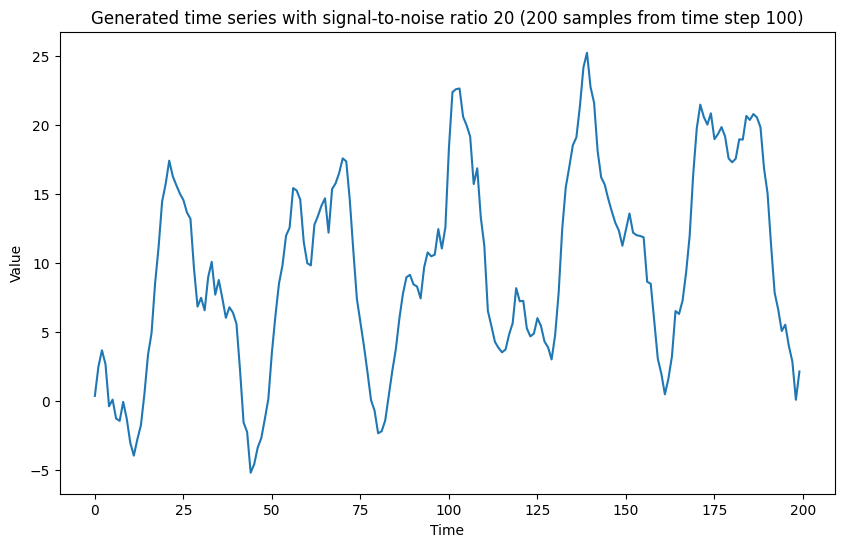

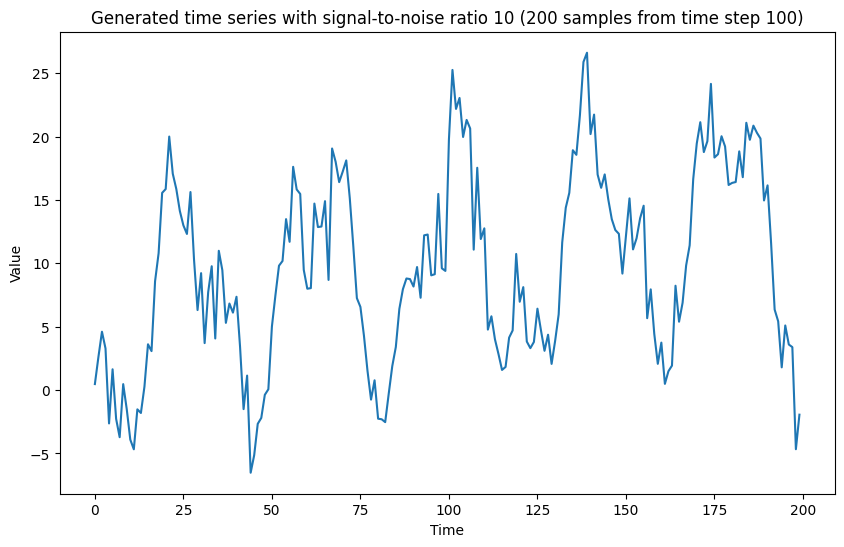

In [37]:
ts_generator = SNRGenerator(linear_trend = 0.05)
ts_generator.generate_series_without_noise()

series_without_noise = ts_generator.series_without_noise
series_with_noise_snr_20 = ts_generator.add_noise(20)
series_with_noise_snr_10 = ts_generator.add_noise(10)

# save_to_csv(series_without_noise, "./dataset/synthetic/", "Trend_SNR_infty.csv")
# save_to_csv(series_with_noise_snr_20, "./dataset/synthetic/", "Trend_SNR_20.csv")
# save_to_csv(series_with_noise_snr_10, "./dataset/synthetic/", "Trend_SNR_10.csv")

plot_series_without_noise(series_without_noise, start_index=100, num_samples=200)
plot_series_with_noise(series_with_noise_snr_20, snr=20, start_index=100, num_samples=200)
plot_series_with_noise(series_with_noise_snr_10, snr=10, start_index=100, num_samples=200)